# Climate-Economic Correlation Analysis

This notebook analyzes correlations between climate variables (from ERA5-Land reanalysis data) and macroeconomic indicators across different countries.

## Objective
- Process hourly ERA5-Land climate data (temperature, precipitation, evaporation)
- Align climate variables with quarterly economic data by country
- Compute spatial averages over country regions
- Analyze correlations between climate anomalies and economic performance

## Data Sources
- **Climate Data**: ERA5-Land hourly reanalysis (1980-2024)
- **Economic Data**: Quarterly macroeconomic indicators by country (`df_country_data_climate.xlsx`)

## Setup and Configuration

In [79]:
import os
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
import pickle
from tqdm import tqdm

# HDF5 locking issues (Rockfish/HPC): set once per process if needed
os.environ.setdefault("HDF5_USE_FILE_LOCKING", "FALSE")
os.environ["NETCDF_HDF5_FILE_LOCKING"] = "FALSE"

#xr.set_options(display_style="text") # Display xarray in plain text

# --path--
# era5land_quarterly_data = "/vast/bzaitch1/trp_climate_model_data/era5land_1970_2024_qtrmean" # Location on Rockfish
era5land_quarterly_data_directory = Path("/Users/kris/Local Job Backup/era5land_1970_2024_qtrmean/") # Location on local machine
# era5land_quarterly_data_directory = Path("/Users/kris/Local Job Backup/test set/") # Location on local machine
#output_directory  = "/vast/bzaitch1/trp_climate_model_data/out"
#os.makedirs(output_directory, exist_ok=True)


var_aliases = {
    'tp' : 'total precipitation', 
    't2m' : '2 metre temperature',
    'e':'evaporation',
}

df = pd.ExcelFile("./df_country_data_climate.xlsx")
#list_countries = df.sheet_names
# for country in tqdm(list_countries):
#     print(country)
# econ = pd.read_excel(df, sheet_name=list_countries[0])
# econ['Unnamed: 0']

In [80]:
pd.read_excel(df)

,time,y,Dp,eq,ep,r,ys,Dps,eqs,rs,lrs,ensos
0,1979-06-30,4.294680,0.217177,0.469586,-3.765026,0.189785,3.762548,0.066749,0.617239,0.036797,0.023604,27.650000
1,1979-09-30,4.310014,0.247843,1.138033,-3.891379,0.209181,3.785753,0.068980,0.615317,0.037415,0.024061,26.853333
2,1979-12-31,4.325347,0.169130,0.745760,-3.958035,0.187465,3.810953,0.066274,0.593414,0.039826,0.026119,26.976667
3,1980-03-31,4.340681,0.169607,0.799297,-4.043055,0.153911,3.831739,0.071565,0.600381,0.045216,0.028752,27.120000
4,1980-06-30,4.324744,0.170991,1.321453,-4.146041,0.140410,3.824674,0.064657,0.612618,0.036963,0.027803,27.900000
...,...,...,...,...,...,...,...,...,...,...,...,...
158,2018-12-31,5.147351,0.126006,-1.151697,-3.829713,0.097424,5.268509,0.004986,2.381566,0.008016,0.004938,27.573333
159,2019-03-31,5.153451,0.099123,-1.158527,-3.876802,0.085092,5.273217,0.004329,2.466975,0.008041,0.004186,27.580000
160,2019-06-30,5.150176,0.098170,-1.314277,-3.857675,0.099560,5.279752,0.008621,2.476471,0.007937,0.003539,28.366667
161,2019-09-30,5.144750,0.095110,-1.511379,-3.812837,0.106039,5.286983,0.005852,2.475464,0.007322,0.002338,27.096667


## Quarterly Time Convention

The economic data uses quarterly periods. We need to establish the fiscal quarter convention to properly align timestamps.

```Q-DEC``` : Q1 = Jan–Mar, Q4 ends Dec.

In [8]:
# QUARTER_RULE = "Q-DEC"  # change if your macro data uses a different fiscal year-end
# econ = pd.read_excel(df, sheet_name=f'Argentina')
# econ["time"] = pd.PeriodIndex(econ['Unnamed: 0'], freq=QUARTER_RULE).to_timestamp(how="end")
# econ["time"][3:] # Start on Q1 of 1980

## Climate Data Loading and Inspection

Load ERA5-Land data to understand structure and available variables (temperature, precipitation, evaporation).

In [ ]:
era5_quarterly_data = era5land_quarterly_data_directory / '1991_Q1_qmean.nc'
ds = xr.open_dataset(str(era5_quarterly_data), engine='netcdf4')
ds.var()

DROP 'number' variable from files made with old pipeline


In [ ]:
# for year in tqdm(range(1980, 1991)):
#     for q in range(1, 5):
#         era5_quarterly_data = era5land_quarterly_data_directory / f'{year}_Q{q}_qmean.nc'
#         #obs_files.append(era5_quarterly_data)
#         ds = xr.open_dataset(str(era5_quarterly_data), engine='netcdf4')
#         if 'number' in ds.variables:  # Use .variables instead of .var()
#             print(f'\n "number" variable found in {year}_Q{q}; dropping...')
#             ds = ds.drop_vars('number')  # ASSIGN back to ds!
#             print(f'Saving to {str(era5land_quarterly_data_directory / 'correction')}/{year}_Q{q}_qmean.nc \n')
#             ds.to_netcdf(str(era5land_quarterly_data_directory / 'correction') + f'/{year}_Q{q}_qmean.nc')
#         else:
#             print(f'No "number" variable in {year}_Q{q}')

In [ ]:
# era5_quarterly_data = era5land_quarterly_data_directory / '*.nc'
# ds = xr.open_mfdataset(str(era5_quarterly_data), engine='netcdf4')
# da = ds['t2m'].drop_vars('number')
# da
# #era5_quarterly_data
# #xr.open_mfdataset('/Users/kris/Local Job Backup/era5land_1970_2024_qtrmean/*.nc', engine='netcdf4')

## Data Preprocessing

### Coordinate Transformations

Prepare the climate data for efficient processing by:
- Convert longitude from 0-360° to -180-180° range
- Ensure latitude is in ascending order
- Convert temperature from Kelvin to Celsius

In [18]:
test_data_set = era5land_quarterly_data_directory /'correction'/ '*.nc'
ds = xr.open_mfdataset(str(test_data_set), engine='netcdf4')
da = ds['t2m']
ds.close()

# --- fix longitude from 0..360 to -180..180 and sort ---
if float(da.longitude.max()) > 180:
    lon_new = ((da.longitude + 180) % 360) - 180
    da = da.assign_coords(longitude=lon_new).sortby("longitude")

# --- make latitude ascending (optional but helpful for weights) ---
if da.latitude[0] > da.latitude[-1]:
    da = da.sortby("latitude")

# --- convert K -> °C ---
if str(da.attrs.get("units", "")).lower() in ("k", "kelvin"):
    da = da - 273.15
    da.attrs["units"] = "degC"

da

<xarray.DataArray 't2m' (valid_time: 44, latitude: 1801, longitude: 3600)> Size: 1GB
dask.array<sub, shape=(44, 1801, 3600), dtype=float32, chunksize=(1, 901, 1800), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 352B 1980-03-31 ... 1990-12-31
  * latitude    (latitude) float64 14kB -90.0 -89.9 -89.8 ... 89.8 89.9 90.0
  * longitude   (longitude) float64 29kB -179.9 -179.8 -179.7 ... 179.9 180.0
Attributes:
    units:    degC

In [17]:
da.dims

('valid_time', 'latitude', 'longitude')

## Detrending Functions
These functions remove seasonal cycles and linear trends from climate data to isolate anomalies:

- **Detrending**: Removes linear trends from time series
- **Seasonal Removal**: Subtracts monthly climatology to get anomalies

This is essential for correlation analysis as we want to compare climate anomalies with economic deviations.

In [19]:
def detrend_dim(da, dim, deg=1):
    p = da.polyfit(dim=dim, deg=deg) #least squares polynomial fit
    fit = xr.polyval(da[dim], p.polyfit_coefficients) # gives line of best fit
    return da - fit #subtracts linear fit from data

def det_data(ds, subset=None):
    """
    Detrend climate data by removing seasonal cycle and linear trend.
    
    Parameters:
    -----------
    ds : xr.DataArray
        Input climate variable
    subset : dict, optional
        Dictionary to subset data for faster testing, e.g.:
        {'lat': slice(-20, 20), 'lon': slice(-80, -40), 'time': slice('1980', '1990')}
    
    Returns:
    --------
    xr.DataArray : Detrended anomalies with preserved attributes
    """
    # Save original metadata
    original_attrs = ds.attrs.copy()
    original_name = ds.name
    
    # Optional subsetting for faster testing
    if subset is not None:
        ds = ds.sel(**subset)
        print(f"Subset to: {ds.sizes}")
    
    # Calculate seasonal climatology for each quarter (Q1, Q2, Q3, Q4)
    climatology = ds.groupby("valid_time.quarter").mean(dim='valid_time')
    
    # Remove seasonal cycle to get anomalies
    anomalies = ds.groupby("valid_time.quarter") - climatology
    
    # Detrend the anomalies (remove linear trend)
    detrend = detrend_dim(anomalies, 'valid_time')
    
    # Restore metadata
    detrend.attrs = original_attrs
    detrend.name = original_name
    
    return detrend

In [30]:
det_da = det_data(da)
# with open('./cache/det_da_test.pkl', 'wb') as f:
#     pickle.dump(det_da.values, f)
# print("Saved detrended data to det_da_test.pkl")

# with open('./cache/det_da_test.pkl', 'rb') as f:
#     det_da = pickle.load(f)
det_da

<xarray.DataArray 't2m' (valid_time: 44, latitude: 1801, longitude: 3600)> Size: 2GB
dask.array<sub, shape=(44, 1801, 3600), dtype=float64, chunksize=(1, 901, 1800), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 352B 1980-03-31 ... 1990-12-31
  * latitude    (latitude) float64 14kB -90.0 -89.9 -89.8 ... 89.8 89.9 90.0
  * longitude   (longitude) float64 29kB -179.9 -179.8 -179.7 ... 179.9 180.0
    quarter     (valid_time) int64 352B 1 2 3 4 1 2 3 4 1 ... 4 1 2 3 4 1 2 3 4
Attributes:
    units:    degC

### (Optional) Checking

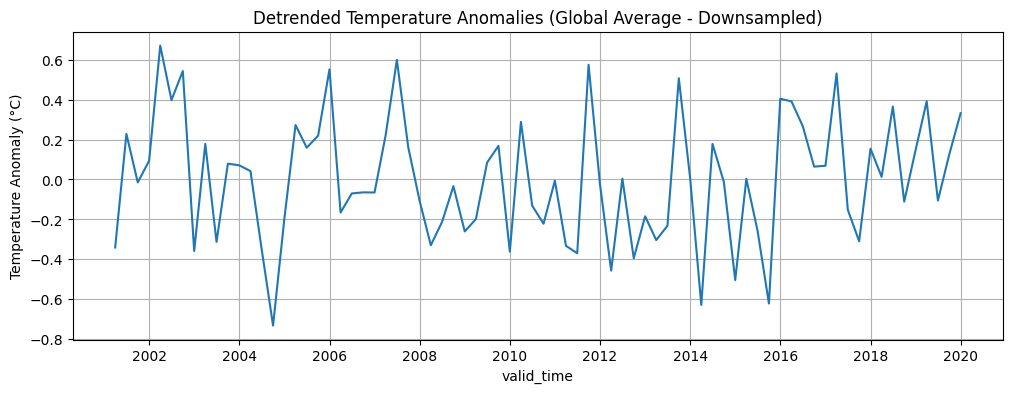

/Users/kris/opt/anaconda3/envs/envs/lib/python3.12/site-packages/dask/array/numpy_compat.py:58: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


In [ ]:
# Quick check: plot detrended anomalies (spatial average time series)
# Use subset for faster plotting
# import matplotlib.pyplot as plt

# # Downsample spatially for quick check (every 20th point)
# det_da_sample = det_da.isel(latitude=slice(None, None, 20), longitude=slice(None, None, 20))

# # Compute and plot
# det_da_sample.mean(dim=['latitude','longitude']).plot(figsize=(12, 4))
# plt.title('Detrended Temperature Anomalies (Global Average - Downsampled)')
# plt.ylabel('Temperature Anomaly (°C)')
# plt.grid(True)
# plt.show()

## Correlation with Econometrics

In [36]:
def correlate_with_econm(det_da, econ_var_series):
    """
    Correlate detrended climate data at every grid point with an economic time series.
    
    Parameters:
    -----------
    det_da : xr.DataArray
        Detrended climate variable (e.g., temperature anomalies) with dimensions (valid_time, latitude, longitude)
    econ_var_series : pd.Series
        Economic indicator time series with datetime index matching climate data times
    
    Returns:
    --------
    xr.DataArray : Correlation coefficients at each grid point (latitude, longitude)
    """
    
    # Find overlapping time period
    climate_times = pd.DatetimeIndex(det_da.valid_time.values)
    econ_times = econ_var_series.index
    
    # Get intersection of times
    common_times = climate_times.intersection(econ_times)
    
    if len(common_times) == 0:
        raise ValueError("No overlapping time periods between climate and economic data!")
    
    print(f"Found {len(common_times)} overlapping time periods")
    
    # Subset both datasets to common times
    det_da_subset = det_da.sel(valid_time=common_times)
    econ_subset = econ_var_series.loc[common_times]
    
    # Remove any NaN values from economic series
    valid_mask = econ_subset.notna()
    if not valid_mask.all():
        print(f"Removing {(~valid_mask).sum()} NaN values from economic series")
        det_da_subset = det_da_subset.sel(valid_time=valid_mask.values)
        econ_subset = econ_subset[valid_mask]
    
    # Convert to xarray DataArray
    econ_da = xr.DataArray(
        econ_subset.values,
        coords={'valid_time': det_da_subset.valid_time},
        dims=['valid_time']
    )
    
    # Use xarray's built-in correlation function
    correlation_map = xr.corr(det_da_subset, econ_da, dim='valid_time')
    
    return correlation_map

In [65]:
# Example: Create correlation map between temperature anomalies and Argentina GDP
# Load Argentina economic data
econ_argentina = pd.read_excel(df, sheet_name='Argentina')

# Prepare economic time series (example with first numeric column)
# Set time index
# econ_argentina['time'] = pd.PeriodIndex(econ_argentina['Unnamed: 0'], freq='Q-DEC').to_timestamp(how='end')
# econ_argentina['time'] = econ_argentina['Unnamed: 0']#.to_timestamp(how='end')
econ_argentina = econ_argentina.set_index('time')
econ_argentina = econ_argentina[3:47]

# Pick an economic variable (e.g., 'gdp', 'cpi', etc. - adjust to your actual column name)
# List available columns first
print("Available economic variables:", econ_argentina.columns.tolist())

# Example: use first numeric column
econ_var_name = econ_argentina.select_dtypes(include=[np.number]).columns[0]
print(f"\nUsing variable: {econ_var_name}")

econ_series = econ_argentina[econ_var_name]

# Compute correlation map
corr_map = correlate_with_econm(det_da, econ_series)
corr_map
# with open('./cache/correlation_maps.pkl', 'wb') as f:
#     pickle.dump(corr_map.values, f)
# print("Saved correlation maps to correlation_maps.pkl")


#Plot the correlation map
# corr_map.plot(figsize=(12, 6), cmap='RdBu_r', vmin=-1, vmax=1, cbar_kwargs={'label': 'Correlation'})
# plt.title(f'Correlation: Temperature Anomalies vs {econ_var_name} (Argentina)')
# plt.xlabel('Longitude')
# plt.ylabel('Latitude')
# plt.show()

KeyError: "None of ['time'] are in the columns"

In [55]:
# DEBUG: Check time alignment and data quality
print("Climate data time range:")
print(f"  Start: {det_da.valid_time.values[0]}")
print(f"  End: {det_da.valid_time.values[-1]}")
print(f"  Length: {len(det_da.valid_time)}")

print("\nEconomic data time range:")
print(f"  Start: {econ_argentina.index[0]}")
print(f"  End: {econ_argentina.index[-1]}")
print(f"  Length: {len(econ_argentina)}")

print(f"\nEconomic variable '{econ_var_name}' stats:")
print(f"  NaN count: {econ_series.isna().sum()}")
print(f"  Valid values: {econ_series.notna().sum()}")
print(f"  Mean: {econ_series.mean():.2f}")
print(f"  Std: {econ_series.std():.2f}")

# Check alignment
econ_aligned = econ_series.reindex(det_da.valid_time.values)
print(f"\nAfter alignment:")
print(f"  NaN count: {econ_aligned.isna().sum()}")
print(f"  Valid values: {econ_aligned.notna().sum()}")

# Check overlap
print("\nFirst 5 times in each:")
print("Climate:", det_da.valid_time.values[:5])
print("Economic:", econ_argentina.index[:5].values)

Climate data time range:
  Start: 1980-03-31T00:00:00.000000000
  End: 1990-12-31T00:00:00.000000000
  Length: 44

Economic data time range:
  Start: 1980-03-31 00:00:00
  End: 1990-12-31 00:00:00
  Length: 44

Economic variable 'y' stats:
  NaN count: 0
  Valid values: 44
  Mean: 4.26
  Std: 0.05

After alignment:
  NaN count: 0
  Valid values: 44

First 5 times in each:
Climate: ['1980-03-31T00:00:00.000000000' '1980-06-30T00:00:00.000000000'
 '1980-09-30T00:00:00.000000000' '1980-12-31T00:00:00.000000000'
 '1981-03-31T00:00:00.000000000']
Economic: ['1980-03-31T00:00:00.000000000' '1980-06-30T00:00:00.000000000'
 '1980-09-30T00:00:00.000000000' '1980-12-31T00:00:00.000000000'
 '1981-03-31T00:00:00.000000000']


In [58]:
corr_map = corr_map.compute()

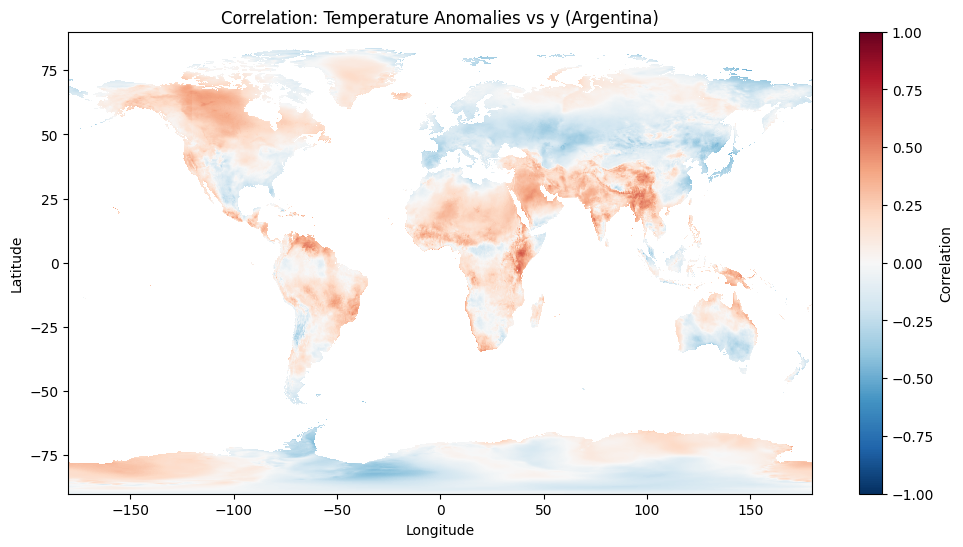

In [61]:
#Plot the correlation map
corr_map.plot(figsize=(12, 6), cmap='RdBu_r', vmin=-1, vmax=1, cbar_kwargs={'label': 'Correlation'})
plt.title(f'Correlation: Temperature Anomalies vs {econ_var_name} (Argentina)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
# Downsample spatially for quick check (every 20th point)
import matplotlib.pyplot as plt
corr_map_sample = corr_map.isel(latitude=slice(None, None, 20), longitude=slice(None, None, 20))

# Compute and plot
det_da_sample.mean(dim=['latitude','longitude']).plot(figsize=(12, 4))
plt.title('Detrended Temperature Anomalies (Global Average - Downsampled)')
plt.ylabel('Temperature Anomaly (°C)')
plt.grid(True)
plt.show()

In [ ]:
# Process all countries and all economic variables
# Store correlation maps in a dictionary
correlation_maps = {}

for country in tqdm(list_countries[:3]):  # Start with first 3 countries for testing
    print(f"\nProcessing {country}...")
    
    # Load economic data
    econ_data = pd.read_excel(df, sheet_name=country)
    econ_data['time'] = pd.PeriodIndex(econ_data['Unnamed: 0'], freq='Q-DEC').to_timestamp(how='end')
    econ_data = econ_data.set_index('time')
    
    # Get all numeric columns
    numeric_cols = econ_data.select_dtypes(include=[np.number]).columns
    
    for econ_var in numeric_cols:
        try:
            econ_series = econ_data[econ_var]
            
            # Skip if too many NaNs
            if econ_series.isna().sum() / len(econ_series) > 0.5:
                continue
            
            # Compute correlation map
            corr_map = correlate_with_econm(det_da, econ_series)
            
            # Store result
            key = f"{country}_{econ_var}"
            correlation_maps[key] = corr_map
            
            print(f"  - Computed correlation map for {econ_var}")
            
        except Exception as e:
            print(f"  - Error with {econ_var}: {e}")

print(f"\nCompleted! Generated {len(correlation_maps)} correlation maps.")

In [ ]:
# Visualize a specific correlation map
# List available maps
print("Available correlation maps:")
for i, key in enumerate(list(correlation_maps.keys())[:10]):  # Show first 10
    print(f"{i}: {key}")

# Plot a specific map (adjust index as needed)
if correlation_maps:
    key = list(correlation_maps.keys())[0]
    corr_map = correlation_maps[key]
    
    fig, ax = plt.subplots(figsize=(14, 7))
    corr_map.plot(ax=ax, cmap='RdBu_r', vmin=-0.8, vmax=0.8, 
                  cbar_kwargs={'label': 'Correlation Coefficient'})
    plt.title(f'Correlation Map: {key}')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(True, alpha=0.3)
    plt.show()

In [ ]:
# Save correlation maps to netCDF or pickle for later use
# Option 1: Save as pickle (easier for dictionary)
# with open('correlation_maps.pkl', 'wb') as f:
#     pickle.dump(correlation_maps, f)
# print("Saved correlation maps to correlation_maps.pkl")

# Option 2: Save individual maps as netCDF
# for key, corr_map in correlation_maps.items():
#     corr_map.to_netcdf(f'corr_maps/{key}.nc')